<a href="https://colab.research.google.com/github/KwonYN/TIL/blob/master/PYTHON/TENSORFLOW2/03_01_rnn_stock_7_kyn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **실습 3-1 : RNN Basic**


## **Import Module**

In [0]:
%tensorflow_version 2.x

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


tf.__version__

'2.0.0'

## **DataSet**

### Mount

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Load

In [0]:
import pandas as pd
# data file path declare
stock_file = '/content/drive/Shared drives/scsa_2019_e/z_data/data-02-stock_daily.csv'
# read the data file
pd_data = pd.read_csv(stock_file)
# 처음 몇개 자료 확인
pd_data.head()

,,,,# http://finance.yahoo.com/quote/GOOG/history?ltr=1
# Open,High,Low,Volume,Close
828.659973,833.450012,828.349976,1247700,831.659973
823.02002,828.070007,821.655029,1597800,828.070007
819.929993,824.400024,818.97998,1281700,824.159973
819.359985,823,818.469971,1304000,818.97998


### Check dataset

### Preprocessing

In [0]:
# 최대,최소값으로 정규화 하기
def MinMaxScaler(data):
  numerator = data - np.min(data, 0)
  denominator = (np.max(data, 0) - np.min(data, 0)) + 1e-7
  return numerator/denominator

In [0]:
# data loading: csv file에서 숫자 데이터를 ndarray로 load
xy = np.loadtxt(stock_file, delimiter=',')
print(xy.shape)

xy = xy[::-1]           # 과거부터로 정렬 (chronically ordered) - 역으로 순서 바꾼 것!
xy = MinMaxScaler(xy)   # minmax 정규화
x = xy                  # input data(Open,High,Low,Volume)
y = xy[:, [-1]]         # 종가만 slicing -> target data  - 시작부터 끝까지(행 단위) 가장 마지막(열) 데이터만!! == 그리고 그것이 종가!

# data type 확인
print ("SHAPE OF X IS %s" % (x.shape,))
print ("SHAPE OF Y IS %s" % (y.shape,))

(732, 5)
SHAPE OF X IS (732, 5)
SHAPE OF Y IS (732, 1)


In [0]:
# sequence generator
## x:7일치 데이터, y:8일차 종가
timesteps = seq_length = 7
data_dim  = 5
dataX = []
dataY = []
for i in range(0, len(y) - seq_length):
    _x = x[i:i + seq_length] # 7일치 데이터
    _y = y[i + seq_length]   # 다음날 종가
    dataX.append(_x)
    dataY.append(_y)

# train data : test data = 7 : 3
train_size = int(len(dataY) * 0.7)
test_size  = len(dataY) - train_size
x_train = np.array(dataX[0:train_size])
y_train = np.array(dataY[0:train_size])
x_test  = np.array(dataX[train_size:len(dataX)])
y_test  = np.array(dataY[train_size:len(dataY)])

In [0]:
def print_np(_name, _x):
    print("TYPE  OF [%s] is [%s]" % (_name, type(_x)))
    print("SHAPE OF [%s] is %s" % (_name, _x.shape))
    print()

In [0]:
print_np('x_train', x_train)
print_np('y_train', y_train)
print_np('x_test', x_test)
print_np('y_test', y_test)

TYPE  OF [x_train] is [<class 'numpy.ndarray'>]
SHAPE OF [x_train] is (507, 7, 5)

TYPE  OF [y_train] is [<class 'numpy.ndarray'>]
SHAPE OF [y_train] is (507, 1)

TYPE  OF [x_test] is [<class 'numpy.ndarray'>]
SHAPE OF [x_test] is (218, 7, 5)

TYPE  OF [y_test] is [<class 'numpy.ndarray'>]
SHAPE OF [y_test] is (218, 1)



## **Model**

### Define

In [0]:
hidden_dim = 10

#### Basic LSTM model 

#basic model = LSTM + dense : Layer 2개
model_B = tf.keras.models.Sequential(name='model_basic')  
model_B.add(tf.keras.layers.LSTM(units = hidden_dim, 
              input_shape = (x_train.shape[1], x_train.shape[2])))
model_B.add(tf.keras.layers.Dense(units = 1))

#### Advanced model: stacked LSTM
#Advance mode = (LSTM) * 3 + dense : Layer 4대
# layer 1
model_A = tf.keras.models.Sequential(name='model_advanced') 
model_A.add(tf.keras.layers.LSTM(units = hidden_dim,
              return_sequences = True, 
              input_shape = (x_train.shape[1], x_train.shape[2])))
# layer 2
model_A.add(tf.keras.layers.LSTM(units = hidden_dim,return_sequences = True))
# layer 3
model_A.add(tf.keras.layers.LSTM(units = hidden_dim))
# dense
model_A.add(tf.keras.layers.Dense(units = 1))

# model summary
model_B.summary()   # basic model
model_A.summary()   # advanced model



Model: "model_basic"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 10)                640       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 651
Trainable params: 651
Non-trainable params: 0
_________________________________________________________________
Model: "model_advanced"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 7, 10)             640       
_________________________________________________________________
lstm_10 (LSTM)               (None, 7, 10)             840       
_________________________________________________________________
lstm_11 (LSTM)               (None, 10)                840       
_________________________________

### Compile and Fit

Epoch 100/100
507/507 [==============================] - 0s 220us/sample - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0019 - val_mse: 0.0019
CPU times: user 17.2 s, sys: 910 ms, total: 18.1 s

Wall time: 14.4 s (@Notebook Setting/GPU)

In [0]:
%%time
# model compile
model_B.compile(optimizer = 'adam', loss = 'mse', metrics=['mse'])

history_B = model_B.fit(x_train, y_train, 
                      validation_data=(x_test, y_test),
                      epochs = 100, batch_size = 32)

Train on 507 samples, validate on 218 samples
Epoch 1/100
507/507 [==============================] - 5s 10ms/sample - loss: 0.2586 - mse: 0.2586 - val_loss: 0.8511 - val_mse: 0.8511
Epoch 2/100
507/507 [==============================] - 0s 201us/sample - loss: 0.1380 - mse: 0.1380 - val_loss: 0.4976 - val_mse: 0.4976
Epoch 3/100
507/507 [==============================] - 0s 183us/sample - loss: 0.0655 - mse: 0.0655 - val_loss: 0.2446 - val_mse: 0.2446
Epoch 4/100
507/507 [==============================] - 0s 182us/sample - loss: 0.0295 - mse: 0.0295 - val_loss: 0.1048 - val_mse: 0.1048
Epoch 5/100
507/507 [==============================] - 0s 188us/sample - loss: 0.0188 - mse: 0.0188 - val_loss: 0.0506 - val_mse: 0.0506
Epoch 6/100
507/507 [==============================] - 0s 176us/sample - loss: 0.0135 - mse: 0.0135 - val_loss: 0.0382 - val_mse: 0.0382
Epoch 7/100
507/507 [==============================] - 0s 175us/sample - loss: 0.0091 - mse: 0.0091 - val_loss: 0.0278 - val_mse: 0.0

Epoch 100/100
507/507 [==============================] - 0s 563us/sample - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0090 - val_mse: 0.0090
CPU times: user 50.9 s, sys: 2.65 s, total: 53.6 s

Wall time: 36.8 s

In [0]:
%%time
# model compile
model_A.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mse'])

history_A = model_A.fit(x_train, y_train, 
                      validation_data=(x_test, y_test),
                      epochs = 100, batch_size = 32)


Train on 507 samples, validate on 218 samples
Epoch 1/100
507/507 [==============================] - 5s 9ms/sample - loss: 0.0676 - mse: 0.0676 - val_loss: 0.1546 - val_mse: 0.1546
Epoch 2/100
507/507 [==============================] - 0s 285us/sample - loss: 0.0210 - mse: 0.0210 - val_loss: 0.0268 - val_mse: 0.0268
Epoch 3/100
507/507 [==============================] - 0s 309us/sample - loss: 0.0122 - mse: 0.0122 - val_loss: 0.0256 - val_mse: 0.0256
Epoch 4/100
507/507 [==============================] - 0s 289us/sample - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 5/100
507/507 [==============================] - 0s 288us/sample - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 6/100
507/507 [==============================] - 0s 294us/sample - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 7/100
507/507 [==============================] - 0s 297us/sample - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0024 - val_mse: 0.00

## **Analysis**

### Plot

In [0]:
print(history_B.history.keys())   # check generated metrics

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


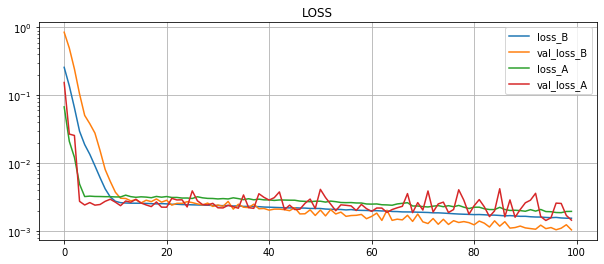

In [0]:
losses_B = history_B.history['loss']
val_loss_B = history_B.history['val_loss']
losses_A = history_A.history['loss']
val_loss_A = history_A.history['val_loss']
plt.figure(figsize=(10, 4))
plt.semilogy(losses_B, label='loss_B')
plt.semilogy(val_loss_B, label='val_loss_B')
plt.semilogy(losses_A, label='loss_A')
plt.semilogy(val_loss_A, label='val_loss_A')
plt.grid(True)
plt.legend(loc='best')
plt.title("LOSS")
plt.show()  

### Predict the stock price

In [0]:
predicted_stock_price_B = model_B.predict(x_test)
predicted_stock_price_A = model_A.predict(x_test)

### Plot the result

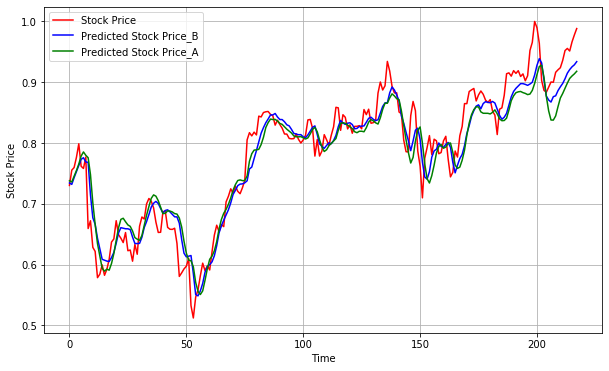

In [0]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, color = 'red', label = 'Stock Price')
plt.plot(predicted_stock_price_B, color = 'blue', label = 'Predicted Stock Price_B')
plt.plot(predicted_stock_price_A, color = 'green', label = 'Predicted Stock Price_A')
#plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

## **실습 과제**

### 과제 1. `timesteps = seq_length = 7`를 줄여보자 
#### -- model_B에서 5,3,1로 줄이고 결과를 비교하자:

### 과제 2. model_A를 교재와 같이 확장시켜 model_A2를 만들어 보자
#### -- dropout layer를 추가하고, 
#### -- LSTM layer도 추가하자
#### -- 결과를 model_B,A,A2에 대해 비교하자:




